In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

In [2]:
# Download monthly historical stock price (example with Apple')
INPUT_PATH = "C:/Users/<YOUR PATH>/inputs/AAPL.csv"

df = pd.read_csv(INPUT_PATH, delimiter=",", parse_dates=["Date"], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df.rename(columns={"Adj Close": "adj_close"}, inplace=True)
df = df[["adj_close"]]
df.head()

,adj_close
Date,
2016-09-01,26.505720
2016-10-01,26.620598
2016-11-01,25.912533
2016-12-01,27.294590
2017-01-01,28.597815


In [3]:
df.drop(df.tail(1).index,inplace=True) # drop last row which mid august data point. We want only 1 data point per month

Text(0.5, 1.0, '5 years Apple stock price')

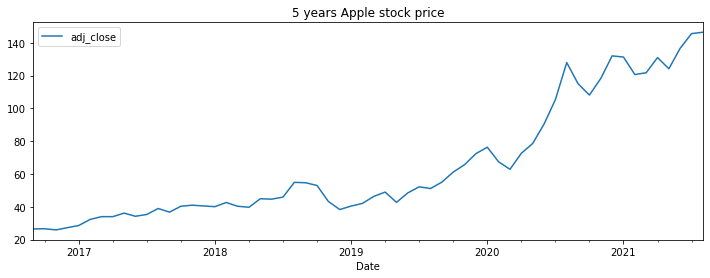

In [4]:
# General info
df.plot(figsize=(12, 4))
plt.title('5 years Apple stock price')

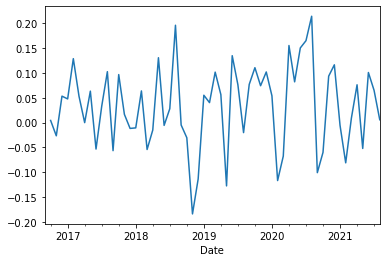

In [5]:
# Compute returns
df['ret'] = (df.adj_close - df.adj_close.shift(1))/df.adj_close.shift(1)
df['ret'].plot()

In [6]:
# Estimate GBM parameters based on 1 year lookback
df_1yr = df.loc['2020-07-01':]
mu = df_1yr['ret'].mean() # mean
sigma = df_1yr['ret'].std() # volatility
print("mu_hat: ", mu)
print("std_hat: ", sigma)

mu_hat:  0.03905575317300421
std_hat:  0.09513126844509975


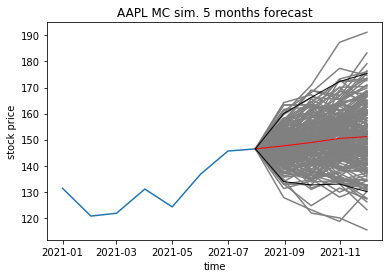

In [7]:
#######
# GBM #
#######

# Parameters
M = 200                                       # Number of simulations
T = 5                                         # Number of months to forecast
S_t = np.zeros([T, M])
S_t[0, :] = df.iloc[[-1]].values[0][0]        # initial price is the last price of our TS
dt = 1/T                                      # time increment between 2 points
W_t = np.random.normal(0, 1, [T, M])

for i in range(T-1):
    for j in range(M):
        S_t[i+1, j] = S_t[i, j] * np.exp((mu - (sigma**2)/2)*dt + sigma*np.sqrt(dt)*W_t[i, j])

# Computing the mean and percentiles
drift = np.mean(S_t, axis=1)
lower, upper = np.percentile(S_t, [2.5, 97.5], axis=1)

# Plot section
time = pd.date_range(start=df.index[-1] - relativedelta(months=1), periods=T, freq='M')

plt.figure(num=1)
plt.plot(df.loc['2021'].index, df.loc['2021'].adj_close)
plt.plot(time, S_t, '#808080')
plt.plot(time, drift, '-r', linewidth=1.0)
plt.plot(time, lower, '-k', linewidth=1.0)
plt.plot(time, upper, '-k', linewidth=1.0)
plt.xlabel('time')
plt.ylabel('stock price')
plt.title('AAPL MC sim. 5 months forecast')

plt.savefig('aapl_mc_sim_5months.png', facecolor='lightgrey', bbox_inches='tight')
plt.show()